In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import soundfile as sf
import pandas as pd
import os

In [ ]:

# ===============================
# PARAMETERS
# ===============================
fs_orig = 44100      # original sampling rate (Hz)
duration = 0.5       # seconds
t = np.linspace(0, duration, int(fs_orig*duration), endpoint=False)

In [ ]:
# ===============================
# (1) CREATE A SYNTHETIC SPEECH SIGNAL (SOURCE-FILTER MODEL)
# ===============================
f0 = 120  # fundamental frequency (Hz), typical male voice

# Source: impulse train for voiced speech
imp_period = int(fs_orig / f0)
source = np.zeros_like(t)
source[::imp_period] = 1.0

# Apply a simple glottal pulse shape
glottal_shape = signal.windows.tukey(imp_period, alpha=0.5)[:imp_period]
source = np.convolve(source, glottal_shape, mode='same')

# Add aspiration noise (unvoiced component)
noise = 0.02 * np.random.randn(len(t))
source = source + noise

# Vocal-tract filter (all-pole, with formant resonances)
formants = [700, 1200, 2600]  # formant frequencies in Hz
bandwidths = [80, 100, 200]   # bandwidths in Hz
a_poly = np.array([1.0])

for F, B in zip(formants, bandwidths):
    r = np.exp(-np.pi * B / fs_orig)
    theta = 2 * np.pi * F / fs_orig
    sec = [1, -2*r*np.cos(theta), r**2]
    a_poly = np.convolve(a_poly, sec)

# Filter the source through the vocal tract
synth = signal.lfilter([1.0], a_poly, source)
synth = synth / np.max(np.abs(synth))  # normalize
orig_signal = synth.copy()

In [ ]:
# ===============================
# (2) SAMPLING & RECONSTRUCTION
# ===============================
sample_rates = [8000, 16000, 44100]  # test sampling rates

def sample_signal(x, fs_from, fs_to):
    """Downsample signal with anti-aliasing filter."""
    if fs_to == fs_from:
        return x, np.arange(len(x))/fs_from
    q = int(round(fs_from/fs_to))
    y = signal.decimate(x, q, ftype='iir', zero_phase=True)
    t_y = np.arange(len(y))/fs_to
    return y, t_y

def reconstruct_zoh(sampled, t_sampled, t_target):
    f = interp1d(t_sampled, sampled, kind='nearest',
                 bounds_error=False, fill_value=(sampled[0], sampled[-1]))
    return f(t_target)

def reconstruct_linear(sampled, t_sampled, t_target):
    f = interp1d(t_sampled, sampled, kind='linear',
                 bounds_error=False, fill_value="extrapolate")
    return f(t_target)

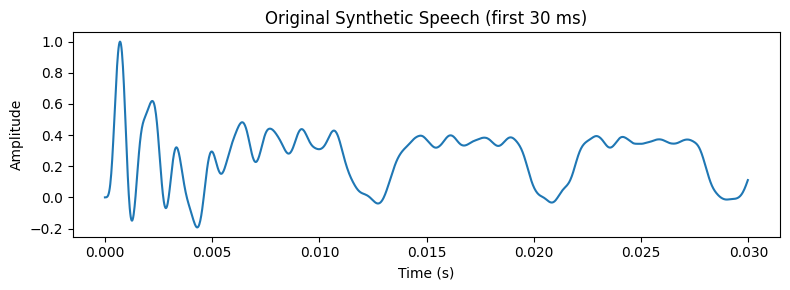

In [ ]:

# Create output folder
os.makedirs("lab1_outputs", exist_ok=True)

results = []
seg_samples = int(0.03 * fs_orig)  # 30 ms for plotting

# Plot original waveform
plt.figure(figsize=(8,3))
plt.plot(t[:seg_samples], orig_signal[:seg_samples])
plt.title("Original Synthetic Speech (first 30 ms)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.tight_layout()
plt.savefig("lab1_outputs/original_signal.png")
plt.show()


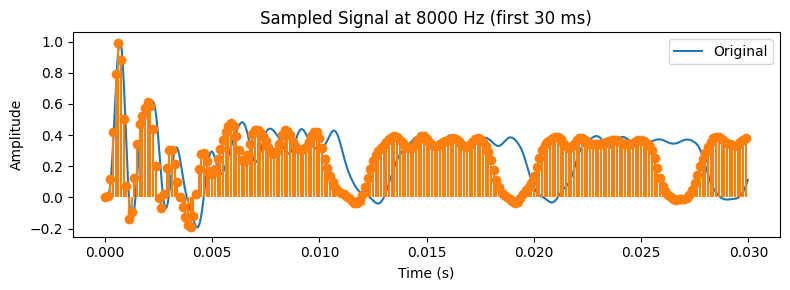

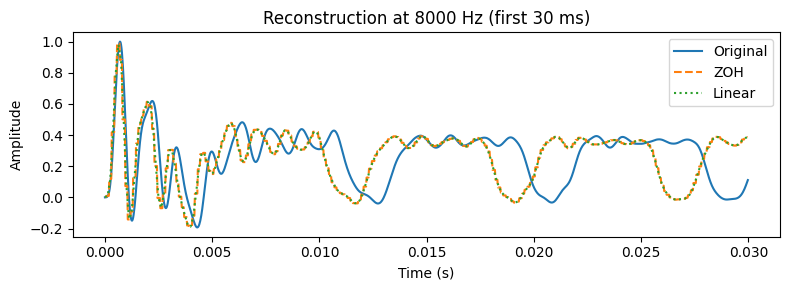

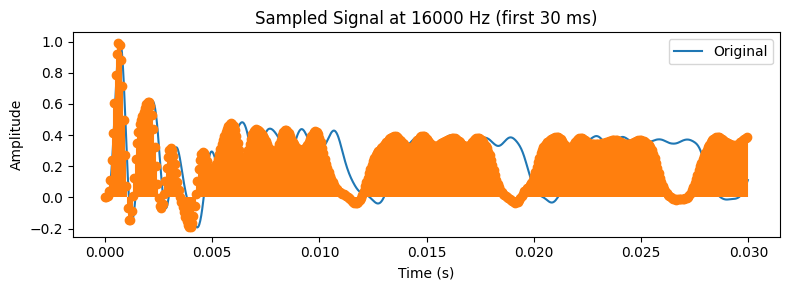

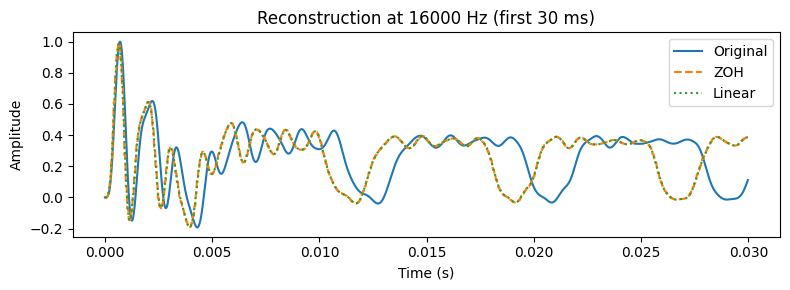

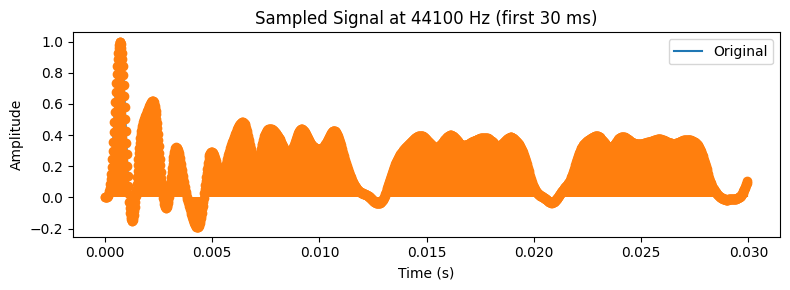

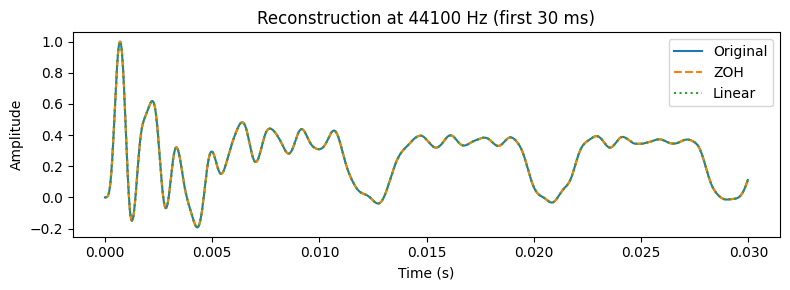

   sample_rate   MSE_ZOH    MSE_Linear
0         8000  0.039814  3.518297e-01
1        16000  0.039850  8.074391e-01
2        44100  0.000000  7.904876e-30
3         8000  0.039814  3.518297e-01
4        16000  0.039850  8.074391e-01
5        44100  0.000000  7.904876e-30


In [ ]:

# Process each sampling rate
for sr in sample_rates:
    sampled, t_sampled = sample_signal(orig_signal, fs_orig, sr)

    # Reconstruction
    recon_zoh = reconstruct_zoh(sampled, t_sampled, t)
    recon_lin = reconstruct_linear(sampled, t_sampled, t)

    # MSE
    mse_zoh = np.mean((orig_signal - recon_zoh)**2)
    mse_lin = np.mean((orig_signal - recon_lin)**2)

    results.append({
        "sample_rate": sr,
        "MSE_ZOH": mse_zoh,
        "MSE_Linear": mse_lin
    })

    # Plot sampled points
    plt.figure(figsize=(8,3))
    plt.plot(t[:seg_samples], orig_signal[:seg_samples], label="Original")
    mask = t_sampled < (t[:seg_samples].max())
    plt.stem(t_sampled[mask], sampled[mask], linefmt="C1-", markerfmt="C1o", basefmt=" ")
    plt.title(f"Sampled Signal at {sr} Hz (first 30 ms)")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"lab1_outputs/sampled_{sr}Hz.png")
    plt.show()

    # Plot reconstruction
    plt.figure(figsize=(8,3))
    plt.plot(t[:seg_samples], orig_signal[:seg_samples], label="Original")
    plt.plot(t[:seg_samples], recon_zoh[:seg_samples], "--", label="ZOH")
    plt.plot(t[:seg_samples], recon_lin[:seg_samples], ":", label="Linear")
    plt.title(f"Reconstruction at {sr} Hz (first 30 ms)")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"lab1_outputs/reconstruction_{sr}Hz.png")
    plt.show()

    # Save audio for listening
    sf.write(f"lab1_outputs/original.wav", orig_signal, fs_orig)
    sf.write(f"lab1_outputs/recon_zoh_{sr}Hz.wav", recon_zoh, fs_orig)
    sf.write(f"lab1_outputs/recon_lin_{sr}Hz.wav", recon_lin, fs_orig)

# ===============================
# (3) SAVE RESULTS
# ===============================
df = pd.DataFrame(results)
df.to_csv("lab1_outputs/mse_results.csv", index=False)
print(df)
